In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import statsmodels.formula.api as smf
import statsmodels.api as sm

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Simulating Time Series Data

We will very naively simulate time series data below

In [2]:
SEED = 99


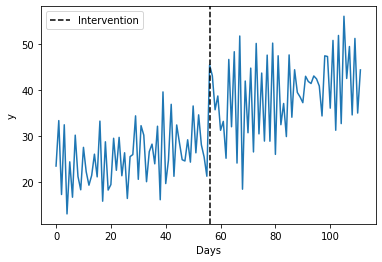

In [3]:
N = 112

np.random.seed(SEED)
ARMA = sm.tsa.ArmaProcess(ar=[1, .8], ma=[1])
intervention_effect = np.repeat([0,5], N/2)
seasonal_effect = np.tile([4, 4.5, 2.75, 2, 1, -3, -2], N//7)
trend = .15
metric = (20 + ARMA.generate_sample(nsample=N)*4) + intervention_effect + seasonal_effect + np.arange(N)*trend

# Simply plot
plt.plot( metric )
plt.ylabel("y")
plt.xlabel("Days")
plt.axvline(56, ls="--", color="k", label="Intervention")
plt.legend()

# Scenario

Your company launched an intervention at day 56 to all customers. Your goal is to identify if the intervention had an impact.

The approach to this is simple - simply do some feature engineering to make some variables representing:
 * A pre-existing __trend__, represented via an array [1:N], where N is the length of the time series. So if the length of the time series is 16, the trend=[0,1,2,...,15]
 * A __seasonality__ component, such as day of week, or month, in dummy or factor form. This could also be encoded in a time series model such as a sarima model instead
 * An __intervention__ dummy variable, where 0 represents the pre-intervention period and 1 represents the post intervention period
 * A __trend__ variable, where 0 represents the pre-intervention period and X=[1:n], where n represents the length of the post-intervention period
 * The appropriate __moving average (MA)__ or __autoregressive component (AR)__ for the time series if it's needed
 
Technically you dont need to include all of the time series components if you have strong beliefs that they do not exist in your data. Models themselves are just assumptions, after all. We'll start off simple and ignore the AR/MA time series components

In [4]:
df = pd.DataFrame({
    "y":metric,
    "t":np.arange(len(metric)),
    "dow": np.tile(range(7), 16).astype(str),
    "intervention":np.repeat([0,1],56),
    "trend": np.r_[np.zeros(N//2), np.arange(N//2)],
})

pd.concat((df.head(10), df.tail(10)))


,y,t,dow,intervention,trend
0,23.430565,0,0,0,0.0
1,33.334435,1,1,0,0.0
2,17.235500,2,2,0,0.0
3,32.420848,3,3,0,0.0
4,13.004834,4,4,0,0.0
5,24.350009,5,5,0,0.0
6,16.640714,6,6,0,0.0
7,30.160015,7,0,0,0.0
8,21.159711,8,1,0,0.0
9,18.260881,9,2,0,0.0


In [5]:
model1 = smf.ols("y ~ t + dow + intervention + trend",data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     16.08
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           4.19e-16
Time:                        19:13:38   Log-Likelihood:                -369.17
No. Observations:                 112   AIC:                             758.3
Df Residuals:                     102   BIC:                             785.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       25.5572      2.353     10.859      0.000      20.889      30.225
dow[T.1]        -1.9651      2.421     -0.812      0.419      -6.768       2.838
dow[T.2]        -2.7747      2.422     -1.145      0.255      -7.580       2.030
dow[T.3]        -3.6290      2.424     -1.497      0.137      -8.437       1.179
dow[T.4]        -2.6599      2.427     -1.096      0.276      -7.473       2.153
dow[T.5]        -7.5818      2.430     -3.121      0.002     -12.401      -2.763
dow[T.6]        -7.4432      2.433     -3.059      0.003     -12.269      -2.617
t                0.1293      0.057      2.275      0.025       0.017       0.242
intervention     5.7954      2.604      2.226      0.028       0.630      10.960
trend            0.0371      0.080      0.463      0.644      -0.122       0.196
==============================================================================
Omnibus:                        3.087   Durbin-Watson:                   3.617
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.033
Skew:                          -0.111   Prob(JB):                        0.362
Kurtosis:                       2.378   Cond. No.                         502.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# yhat = model1.params.loc["Intercept"]\
#     + df.t*model1.params.loc["t"]\
#     + df.intervention*model1.params.loc["intervention"]\
#     + df.trend*model1.params.loc["trend"]

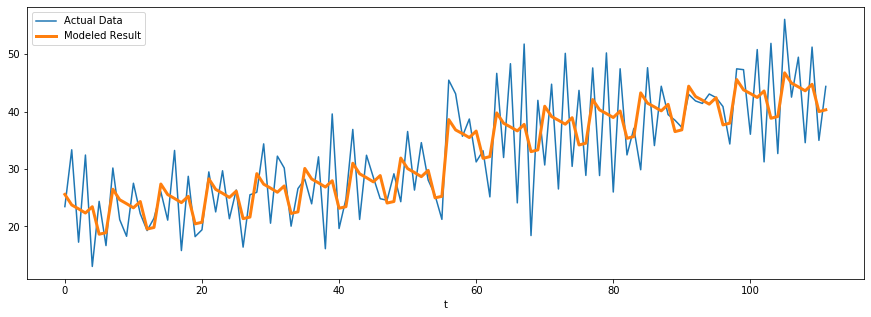

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
df.set_index("t")["y"].plot(label="Actual Data")
model1.predict(df).plot(label="Modeled Result", lw=3)
# plt.plot(yhat)
ax.legend()

Great news, the intervention variable correctly identifies that there's an intervention effect. The bad news is that the 95% confidence interval is very wide.

Looking at the durbin watson statistic (see bottom of model summary), there may be some evidence of autocorrelation. We'll test for this further using the Ljung-Box statistic

In [8]:
_, pval = sm.stats.diagnostic.acorr_ljungbox(model1.resid, lags=range(1,12+1))
pd.DataFrame({"lag":range(1,12+1),"pval":pval},columns=["lag", "pval"]).set_index("lag")

,pval
lag,
1,3.423937e-18
2,1.431223e-28
3,4.504832e-35
4,7.905612e-39
5,1.525277e-42
6,1.448268e-46
7,3.003147e-50
8,2.691764e-53
9,8.428112e-55


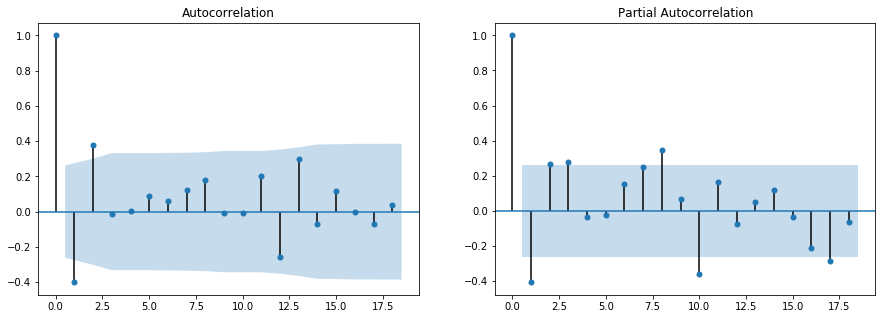

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sm.tsa.graphics.plot_acf(df.y.values[:56],ax=ax[0])
sm.tsa.graphics.plot_pacf(df.y.values[:56],ax=ax[1]);

I wont go into how to identify the right AR/MA components to use, but I will show you what happens when you identify them correctly. Notice how I strictly observe them on the pre-intervention data

In [10]:
y = df.y
X = pd.concat((df.drop(["y","dow"],axis=1), pd.get_dummies(df.dow,drop_first=True)),axis=1)

In [11]:
model2 = sm.tsa.ARIMA(
    endog=y,
    order=[1,0,0],
    exog=X

).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  112
Model:                     ARMA(1, 0)   Log Likelihood                -309.123
Method:                       css-mle   S.D. of innovations              3.805
Date:                Tue, 13 Jul 2021   AIC                            642.246
Time:                        19:13:40   BIC                            674.867
Sample:                             0   HQIC                           655.481
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           25.3974      1.373     18.503      0.000      22.707      28.088
t                0.1328      0.018      7.466      0.000       0.098       0.168
intervention     5.4994      0.817      6.734      0.000       3.899       7.100
trend            0.0353      0.025      1.416      0.160      -0.014       0.084
1               -1.7140      2.345     -0.731      0.467      -6.311       2.883
2               -2.7094      1.403     -1.931      0.056      -5.460       0.041
3               -3.4453      1.934     -1.781      0.078      -7.237       0.346
4               -2.5432      1.915     -1.328      0.187      -6.296       1.209
5               -7.4570      1.428     -5.221      0.000     -10.256      -4.658
6               -7.2786      2.324     -3.131      0.002     -11.834      -2.723
ar.L1.y         -0.8078      0.054    -14.950      0.000      -0.914      -0.702
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2380           +0.0000j            1.2380            0.5000
-----------------------------------------------------------------------------
"""

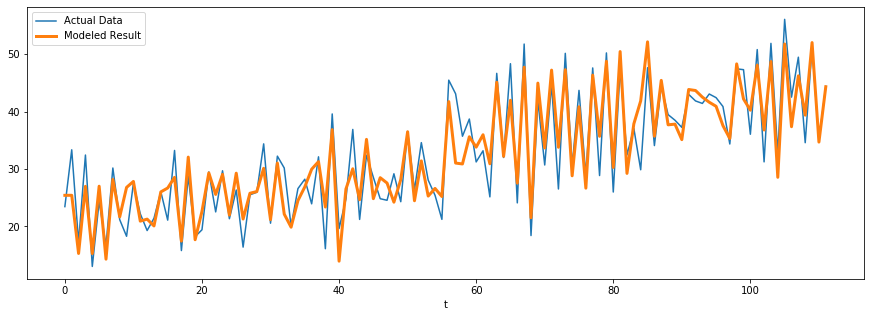

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
df.set_index("t")["y"].plot(label="Actual Data")
model2.predict(exog=X).plot(label="Modeled Result", lw=3)
ax.legend()

Now the intervention effect is both closer to the true estimate, and has a more narrow confidence interval.

Looking at the Ljung Box statistic, the results look much better as well

In [13]:
_, pval = sm.stats.diagnostic.acorr_ljungbox(model2.resid, lags=range(1,12+1))
pd.DataFrame({"lag":range(1,12+1),"pval":pval},columns=["lag", "pval"]).set_index("lag")

,pval
lag,
1,0.748595
2,0.841050
3,0.927211
4,0.214688
5,0.321165
6,0.313292
7,0.317709
8,0.181590
9,0.248862


# Next steps
What happens when you leave out a key component such as trend or seasonality?